In [5]:
def add_src_and_logger(is_renkolab, save_dir):
    import sys
    from pathlib import Path
    import os
    import logging 
    src_path = Path.home() / "work" / "fco2diffusion" / "src"
    if str(src_path) not in sys.path:
        sys.path.insert(0, str(src_path))

    if is_renkolab:
        DATA_PATH = '/home/jovyan/work/datapolybox/'
    else:
        DATA_PATH = '../data/training_data/'
    
    if (save_dir is not None) and (not os.path.exists(save_dir)):
        os.makedirs(save_dir)

    if save_dir is None:
        logging.basicConfig(
            level=logging.INFO, 
            format='%(asctime)s - %(levelname)s - %(message)s'
            )
    else:
        logging.basicConfig(
            filename=save_dir+'training.log',
            filemode='a',
            level=logging.INFO, 
            format='%(asctime)s - %(levelname)s - %(message)s'
            )
    return DATA_PATH, logging

is_renkolab = True
save_dir = None
DATA_PATH, logger = add_src_and_logger(is_renkolab, save_dir)

In [6]:
import torch, platform, os
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version   :", torch.version.cuda)
print("GPU seen       :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "-")

2.6.0+cu124
CUDA available: True
CUDA version   : 12.4
GPU seen       : Tesla P100-PCIE-12GB


In [7]:
import numpy as np

def mirror_shift(row, shift):
    """
    Shift a row of data by a given amount, mirroring the data if the shift goes out of bounds.
    """
    if shift == 0:
        return row
    elif shift > 0:
        return np.concatenate((row[:shift][::-1], row[:-shift]))
    else:
        return np.concatenate((row[-shift:], row[shift:][::-1]))

def segment_sample(data, orientation, segment_len=64, random_offset=0):
    padded_side, _, num_cols = data.shape
    side = padded_side - 2 * segment_len
    if orientation == 'vertical':
        data = np.transpose(data, (1, 0, 2))

    #padded_width = width + 2 * segment_len
    segments = np.zeros(( (side**2) // segment_len, num_cols, segment_len), dtype=np.float32)

    offset = segment_len + random_offset
    for i in range(num_cols):
        segments[:, i, :] = data[segment_len:-segment_len, offset:offset + side, i].reshape((side ** 2) // segment_len, segment_len)
    return segments

from fco2dataset.ucollocate import get_day_data, collocate
def get_day_dataset(date):
    # get global satellite data for a given date
    dss = get_day_data(date, save_path='../data/inference/gridded')
    return dss

def collocate_coords(df, dss, date):
    save_path = '../data/inference/collocated'
    df_collocated = collocate(df, date, save_path=save_path, dss=dss, verbose=False)
    return df_collocated

def normalize(df, stats, mode):
    for i in range(1, len(df.columns)): # first column is the target
        col = df.columns[i - 1]
        # print(f"Normalizing {col} with {mode}")
        if mode == 'min_max':
            # print(f"Min: {stats['mins'][i]}, Max: {stats['maxs'][i]}")
            df[col] = 2 * (df[col] - stats['mins'][i]) / (stats['maxs'][i] - stats['mins'][i]) - 1
        elif mode == 'mean_std':
            df[col] = (df[col] - stats['means'][i]) / stats['stds'][i]
        else:
            raise ValueError(f"Unknown mode {mode}")
    return df

In [4]:
import healpy as hp

def get_nested_patch(patch_ix, patch_size, nside=1024, plot=False):
    patch_pix = np.arange(patch_ix * patch_size, (patch_ix + 1) * patch_size)
    xyf = hp.pix2xyf(nside, patch_pix, nest=True)
    xyf = (xyf[0]  - xyf[0].min(), xyf[1]  - xyf[1].min(), xyf[2])
    lon, lat = hp.pix2ang(nside, patch_pix, nest=True, lonlat=True)

    if plot:
        side = int(np.sqrt(patch_size))
        plot_patch(patch_ix, patch_size, xyf[0] * side + xyf[1], nside=nside)
    return xyf, lon, lat, patch_pix

def plot_patch(patch_ix, patch_size, data, nside=1024):
    npix = hp.nside2npix(nside)
    m = np.full(npix, np.nan)
    patch_pix = np.arange(patch_ix * patch_size, (patch_ix + 1) * patch_size)
    m[patch_pix] = data
    hp.mollview(m, title=f"Patch {patch_ix}", nest=True)


2025-06-24 09:51:18,571 - WARNING - mkdir -p failed for path /home/jovyan/.cache/matplotlib: [Errno 13] Permission denied: '/home/jovyan/.cache/matplotlib'
2025-06-24 09:51:18,574 - WARNING - Matplotlib created a temporary cache directory at /tmp/matplotlib-jhgybayv because there was an issue with the default path (/home/jovyan/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2025-06-24 09:51:19,378 - INFO - generated new fontManager


Number of patches: 48


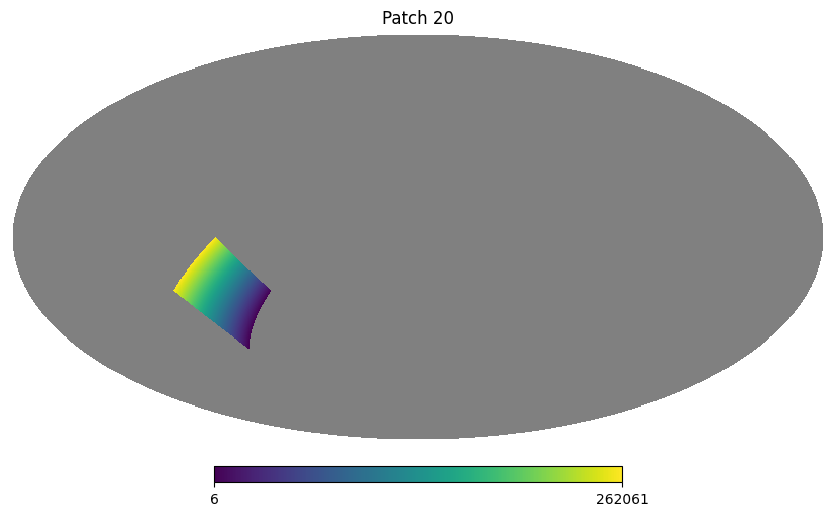

In [5]:
NSIDE = 1024
npix = hp.nside2npix(NSIDE)
face_pixs = npix//12
num_subfaces = 4 # number of subfaces should a power of 4
patch_size = face_pixs // num_subfaces
n_patches = npix // patch_size
print(f"Number of patches: {n_patches}")
xyf, lon, lat, patch_pix = get_nested_patch(20, patch_size, nside=NSIDE, plot=True)


In [6]:
import pandas as pd
from fco2models.utraining import prep_df


def get_patch_ds(params, patch_ix, patch_size, date, nside=NSIDE, dss=None):
    predictors = params['predictors']
    stats = {
    'means':params['train_means'],
    'stds':params['train_stds'],
    'mins':params['train_mins'],
    'maxs':params['train_maxs']
    }

    # get the patch coordinates
    xyf, lon, lat, patch_pix = get_nested_patch(patch_ix, patch_size, nside=nside)
    if dss is None:
        dss = get_day_dataset(date)
    coords = pd.DataFrame({
        'lon': lon.flatten(),
        'lat': lat.flatten(),
        'x': xyf[0].flatten(),
        'y': xyf[1].flatten(),
        'f': xyf[2].flatten(),
        'patch_pix': patch_pix,
    })
    coords['time_1d'] = date
    # collocate the data
    context_df = collocate_coords(coords, dss, date)
    context_df['lon'] = (context_df['lon'] + 180) % 360 - 180
    context_df = prep_df(context_df, with_target=False, with_log=False)[0][predictors + ['x', 'y']]
    context_df = normalize(context_df, stats, params['mode'])
    context_df = context_df.fillna(context_df.mean())  # fill NaNs with mean of each column

    height = width = np.sqrt(patch_size).astype(int)
    context_ds = np.zeros((height, width, len(predictors) + 3), dtype=np.float32)
    x = context_df['x'].values.astype(int)
    y = context_df['y'].values.astype(int)
    for i, col in enumerate(predictors):
        context_ds[x, y, i] = context_df[col].values
    # add lat lon
    context_ds[x, y, -2] = lat
    context_ds[x, y, -1] = lon
    context_ds[x, y, -3] = patch_pix.flatten()

    return context_ds

import torch
from tqdm import tqdm
def infer_patch(model, noise_scheduler, params, patch_ix, patch_size, date, nside=NSIDE, dss=None, jump=20):
    
    # get dataset collocated for the patch
    context_ds = get_patch_ds(params, patch_ix, patch_size, date, nside=nside, dss=dss)
    lat = context_ds[:, :, -2] # later used for plotting
    lon = context_ds[:, :, -1] # later used for plotting
    patch_pix = context_ds[:, :, -3] # later used for plotting
    
    context_ds = context_ds[:, :, :-3] # model input
    side = np.sqrt(patch_size).astype(int)
    segment_len = 64

    # pad the context for random shifts (to avoid edge effects)
    padded_side = side + 2 * segment_len
    padded_context_ds = np.zeros((padded_side, padded_side, context_ds.shape[2]), dtype=np.float32)
    padded_context_ds[segment_len: -segment_len, segment_len: -segment_len, :] = context_ds
    padded_context_ds[segment_len:-segment_len, :segment_len, :] = context_ds[:, :segment_len, :][:, ::-1, :] # just mirror the data for now
    padded_context_ds[segment_len:-segment_len, -segment_len:, :] = context_ds[:, -segment_len:, :][:, ::-1, :]
    
    sample_col = np.random.randn(padded_side, padded_side, 1).astype(np.float32)
    sample_context_ds = np.concatenate([sample_col, padded_context_ds, np.ones_like(sample_col)], axis=2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    step = 0
    t_loop = tqdm(noise_scheduler.timesteps[::jump], desc="Denoising steps")
    
    for t in t_loop:
        random_offset = np.random.randint(-60, 60)
        if step % 2 == 0:
            segments = segment_sample(sample_context_ds.copy(), 'horizontal', segment_len=64, random_offset=random_offset)
        else:
            segments = segment_sample(sample_context_ds.copy(), 'vertical', segment_len=64, random_offset=random_offset)

        ds = torch.from_numpy(segments).to(device).float()
        #print(f"ds shape: {ds.shape}")
        dataloader = torch.utils.data.DataLoader(ds, batch_size=200, shuffle=False)
        samples = []
        for (ix, batch) in enumerate(dataloader):
            with torch.no_grad():
                batch = batch.to(device)
                #context = batch[:, 1:, :].to(device)
                sample_prev = batch[:, 0:1, :].to(device)
                noise_pred = model(batch, t, return_dict=False)[0]
                x_0 = noise_scheduler.step(noise_pred, t, sample_prev).pred_original_sample
                if t - jump > 0:
                    sample = noise_scheduler.add_noise(x_0, torch.randn_like(sample_prev), t - jump)
                else:
                    sample = x_0
                sample[torch.isnan(sample)] = sample_prev[torch.isnan(sample)]
                samples.append(sample.cpu().numpy())
            t_loop.set_postfix({"batch":{ix}})
        
        samples = np.concatenate(samples, axis=0)
        #padded_samples = np.full((padded_side, padded_side, 1), np.nan, dtype=np.float32)
        offset = random_offset + segment_len
        if step % 2 == 0:
            samples = samples.reshape(side, side)
            sample_context_ds[segment_len:-segment_len, offset:offset + side, 0] = samples
            #samples = undo_shift(samples, sample_context_ds, random_offset)
        else:
            samples = samples.reshape(side, side).T
            sample_context_ds[offset:offset + side, segment_len:-segment_len, 0] = samples
            #samples = undo_shift(samples, sample_context_ds, random_offset).T
        
        #samples = samples[:, :, np.newaxis]  # add channel dimension
        #sample_context_ds = np.concatenate([padded_samples, padded_context_ds, np.ones_like(sample_col)], axis=2)
        step += 1
    
    # remove padding from result
    sample_context_ds = sample_context_ds[segment_len:-segment_len, segment_len:-segment_len, :]
    return np.concatenate([sample_context_ds, lat[:,:, np.newaxis], lon[:,:, np.newaxis], patch_pix[:, :, np.newaxis]], axis=2)

There was a problem when trying to write in your cache folder (/home/jovyan/.cache/huggingface/hub). Please, ensure the directory exists and can be written to.


In [ ]:
from fco2models.models import UNet2DModelWrapper, UNet1DModel
from fco2models.ueval import load_model
import torch
# load baseline model
save_path = '../models/newds1/'
model_path = 'e_150.pt'
model_class = UNet2DModelWrapper
model, noise_scheduler, params, losses = load_model(save_path, model_path, model_class)
print("model loaded")
date = pd.Timestamp('2022-10-04')
dss = get_day_dataset(date)

NSIDE = 1024
npix = hp.nside2npix(NSIDE)
face_pixs = npix//12
num_subfaces = 1 # number of subfaces should a power of 4
patch_size = face_pixs // num_subfaces
#print(f"Number of patches: {n_patches}")
print(f"Patch size: {patch_size}")

patch_ixs = range(12)
samples = []
for patch_ix in patch_ixs:
    sample = infer_patch(model, noise_scheduler, params, patch_ix, patch_size, date, nside=NSIDE, dss=dss, jump=5)
    samples.append(sample)

sample = np.concatenate(samples, axis=0)

model loaded
All files reachable for date 2022-10-04 00:00:00
globcolour data already exists at ../data/inference/gridded_2022-10-04/globcolour.nc
soda data already exists at ../data/inference/gridded_2022-10-04/soda.nc
cmems data already exists at ../data/inference/gridded_2022-10-04/cmems.nc
sss_cci data already exists at ../data/inference/gridded_2022-10-04/sss_cci.nc
sss_multiobs data already exists at ../data/inference/gridded_2022-10-04/sss_multiobs.nc
sst_cci data already exists at ../data/inference/gridded_2022-10-04/sst_cci.nc
Reading globcolour data from ../data/inference/gridded_2022-10-04/globcolour.nc
Reading soda data from ../data/inference/gridded_2022-10-04/soda.nc
Reading cmems data from ../data/inference/gridded_2022-10-04/cmems.nc
Reading sss_cci data from ../data/inference/gridded_2022-10-04/sss_cci.nc
Reading sss_multiobs data from ../data/inference/gridded_2022-10-04/sss_multiobs.nc
Reading sst_cci data from ../data/inference/gridded_2022-10-04/sst_cci.nc
Patch si

Denoising steps:  24%|██▎       | 47/200 [01:50<05:56,  2.33s/it, batch={21}]

In [22]:
(np.isnan(sample[:, :, 1]).sum() / sample[:, :, 1].size) * 100

0.0

In [23]:
sample[:10, :, 0]

array([[ 0.01501859,  0.0346024 ,  0.02650286, ...,  0.03760374,
         0.02391383, -0.05269701],
       [ 0.05398569,  0.01424474,  0.00712891, ...,  0.05519277,
         0.09339335,  0.11254591],
       [-0.00424427, -0.00946781,  0.02826653, ...,  0.06610928,
         0.11070525,  0.11598646],
       ...,
       [-0.01180403,  0.00778408, -0.00839127, ...,  0.01589066,
        -0.0728173 , -0.02550514],
       [-0.00867573, -0.01288635, -0.0073441 , ..., -0.03647821,
        -0.05094719, -0.0287263 ],
       [-0.00130933, -0.00487949,  0.03009838, ...,  0.02004343,
        -0.04594931, -0.01583185]], dtype=float32)

In [24]:
sample.shape

(12288, 1024, 17)

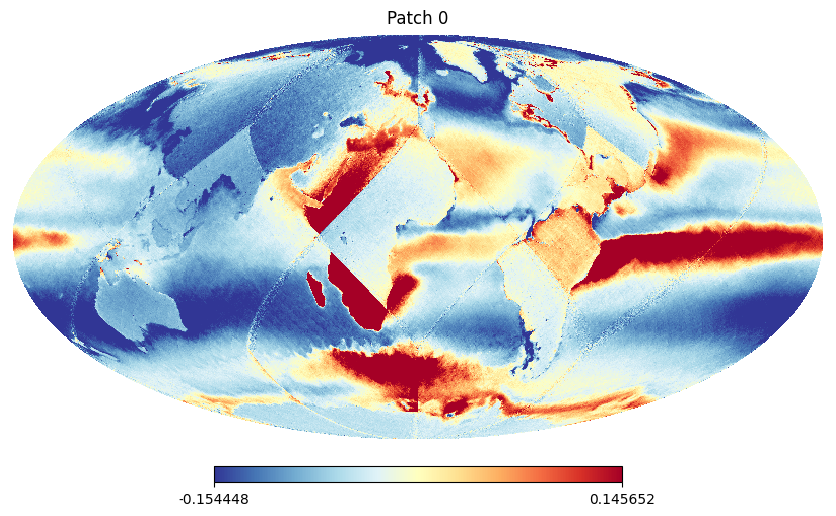

In [25]:
m = np.full(npix, np.nan)
#patch_pix = np.arange(0 * patch_size, (0 + 1) * patch_size)
patch_pix = sample[:, :, -1].flatten().astype(int)
# clip sample between 5th and 95th percentile
feature_ix = 0
sample[np.isnan(sample[:, :, 1]), 0] = np.nan
robust_sample = np.clip(sample[:, :, feature_ix], np.nanpercentile(sample[:, :, feature_ix], 5), np.nanpercentile(sample[:, :, feature_ix], 95))
m[patch_pix] = robust_sample.flatten()
hp.mollview(m, title=f"Patch {0}", nest=True, cmap='RdYlBu_r')

In [26]:
lon, lat = hp.pix2ang(NSIDE, patch_pix, nest=True, lonlat=True)
sample_ds = pd.DataFrame({
    'lon': lon.flatten(),
    'lat': lat.flatten(),
    'fco2': sample[:, :, 0].flatten(),
    'sst_cci': sample[:, :, 1].flatten(),
    'sss_cci': sample[:, :, 2].flatten(),
})
print(sample_ds.lon.min(), sample_ds.lon.max(), sample_ds.lat.min(), sample_ds.lat.max())
sample_ds['lon'] = (sample_ds['lon'] + 180) % 360 - 180  # normalize lon to [-180, 180]
sample_ds['lon'] = np.round(sample_ds['lon']*4, 0) / 4
sample_ds['lat'] = np.round(sample_ds['lat']*4, 0) / 4
sample_ds.set_index(['lon', 'lat'], inplace=True)

0.0 359.95605468749994 -89.95431463934247 89.95431463934247


In [27]:
sample_ds.head()

fco2   sst_cci   sss_cci
lon   lat                               
45.00 0.00  0.015019  0.630584  0.787958
      0.00  0.034602  0.632875  0.775844
      0.00  0.026503  0.634020  0.775844
44.75 0.25  0.026506  0.634020  0.775844
      0.25  0.022438  0.634020  0.775844

In [28]:
import xarray as xr
sample_ds = sample_ds.reset_index()
masks = xr.open_dataset(DATA_PATH+"masks/RECCAP2_masks.nc")
sample_ds["seamask"] = masks.seamask.sel(sample_ds[['lat', 'lon']].to_xarray(), method="nearest")
sample_ds.set_index(['lon', 'lat'], inplace=True)
sample_ds.loc[~(sample_ds.seamask.astype(bool)), 'fco2'] = np.nan

In [29]:
sample_ds.head()

fco2   sst_cci   sss_cci  seamask
lon   lat                                        
45.00 0.00  0.015019  0.630584  0.787958        1
      0.00  0.034602  0.632875  0.775844        1
      0.00  0.026503  0.634020  0.775844        1
44.75 0.25  0.026506  0.634020  0.775844        1
      0.25  0.022438  0.634020  0.775844        1

In [30]:
sample_ds = sample_ds.groupby(['lat', 'lon']).mean().to_xarray()

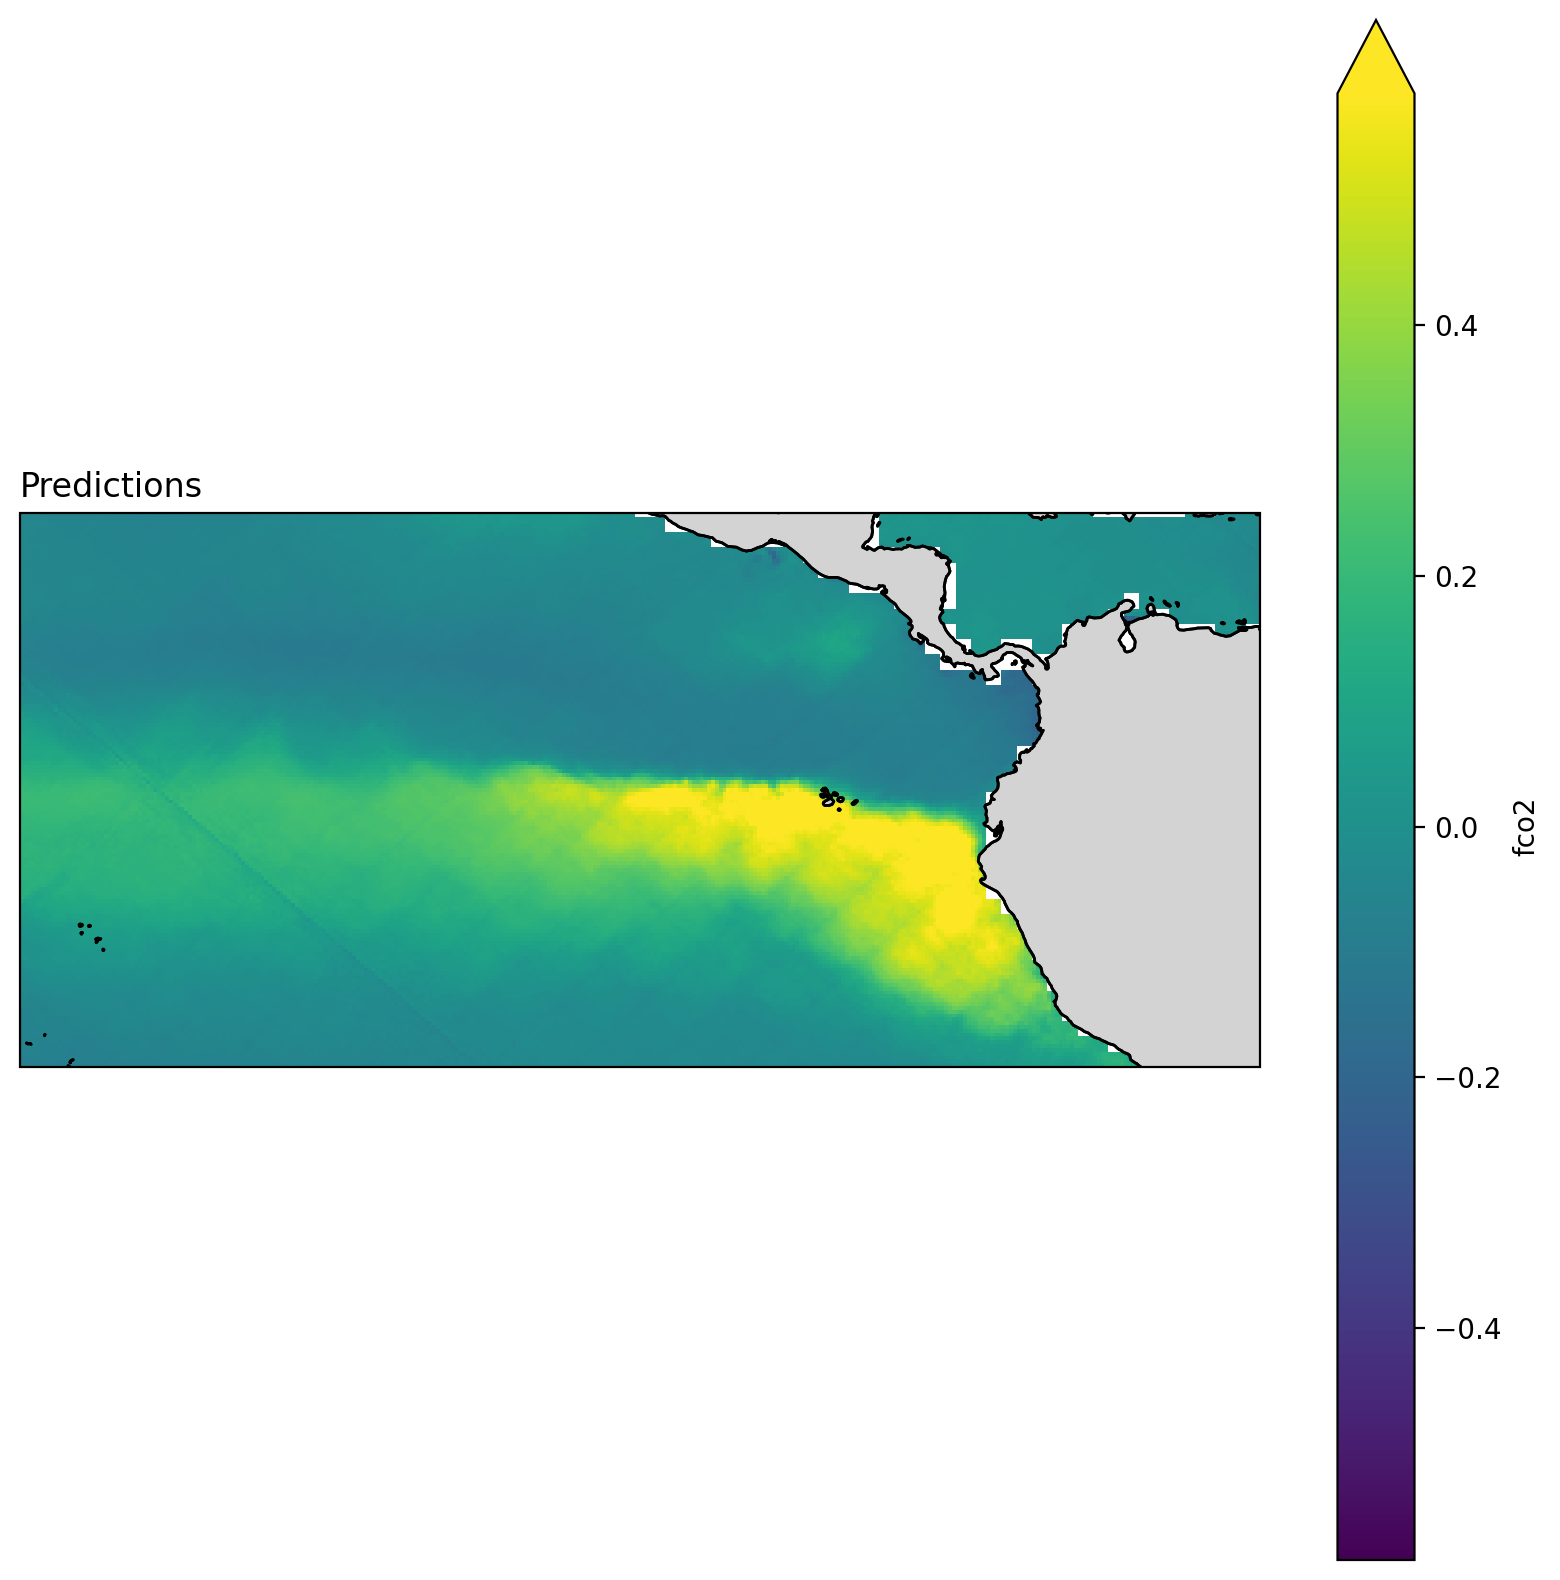

In [31]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmocean import cm as cmo  # registers the cmocean colormaps to matplotlib
fig = plt.figure(figsize=(10, 10), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
malvinas = (-71, -56, -35, -11)  # (lon_min, lat_min, lon_max, lat_max)
eq_pacific = (-144, -18, -63, 18) 
lon_min, lat_min, lon_max, lat_max = eq_pacific
#ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='lightgrey')
ax.add_feature(cfeature.COASTLINE, zorder=2, edgecolor='black')

ax.set_title('Predictions', fontsize=12, loc='left')

(sample_ds
 .sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
 .fco2
 #.ffill(dim='lat')
 .plot
 .imshow(cmap='viridis', 
         ax=ax, add_colorbar=True, 
         transform=ccrs.PlateCarree(), 
         robust=True,
         #vmax=0.8,
         #vmin=-0.8
         #interpolation='gaussian',
         )
)
plt.show()

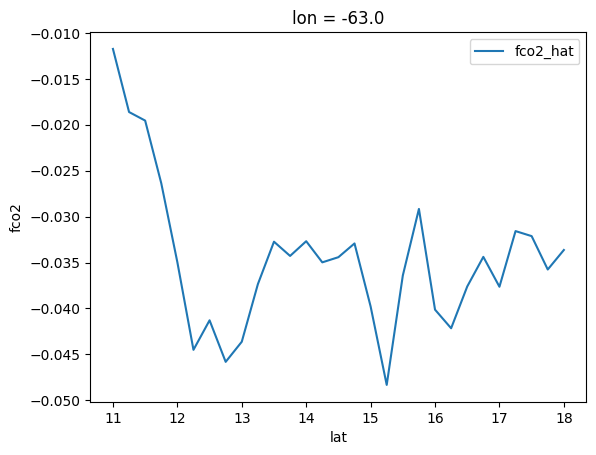

In [32]:
fig, ax = plt.subplots()
lat_plot = slice(lat_min, lat_max)
lon_plot = lon_max
sample_ds.fco2.sel(lat=lat_plot, lon=lon_plot).plot(ax=ax, label='fco2_hat')
#sample_ds.sst_cci.sel(lat=lat_plot, lon=lon_plot).plot(ax=ax, label='sst_cci')
#sample_ds.sss_cci.sel(lat=lat_plot, lon=lon_plot).plot(ax=ax, label='sss_cci')
fig.show()
ax.legend()

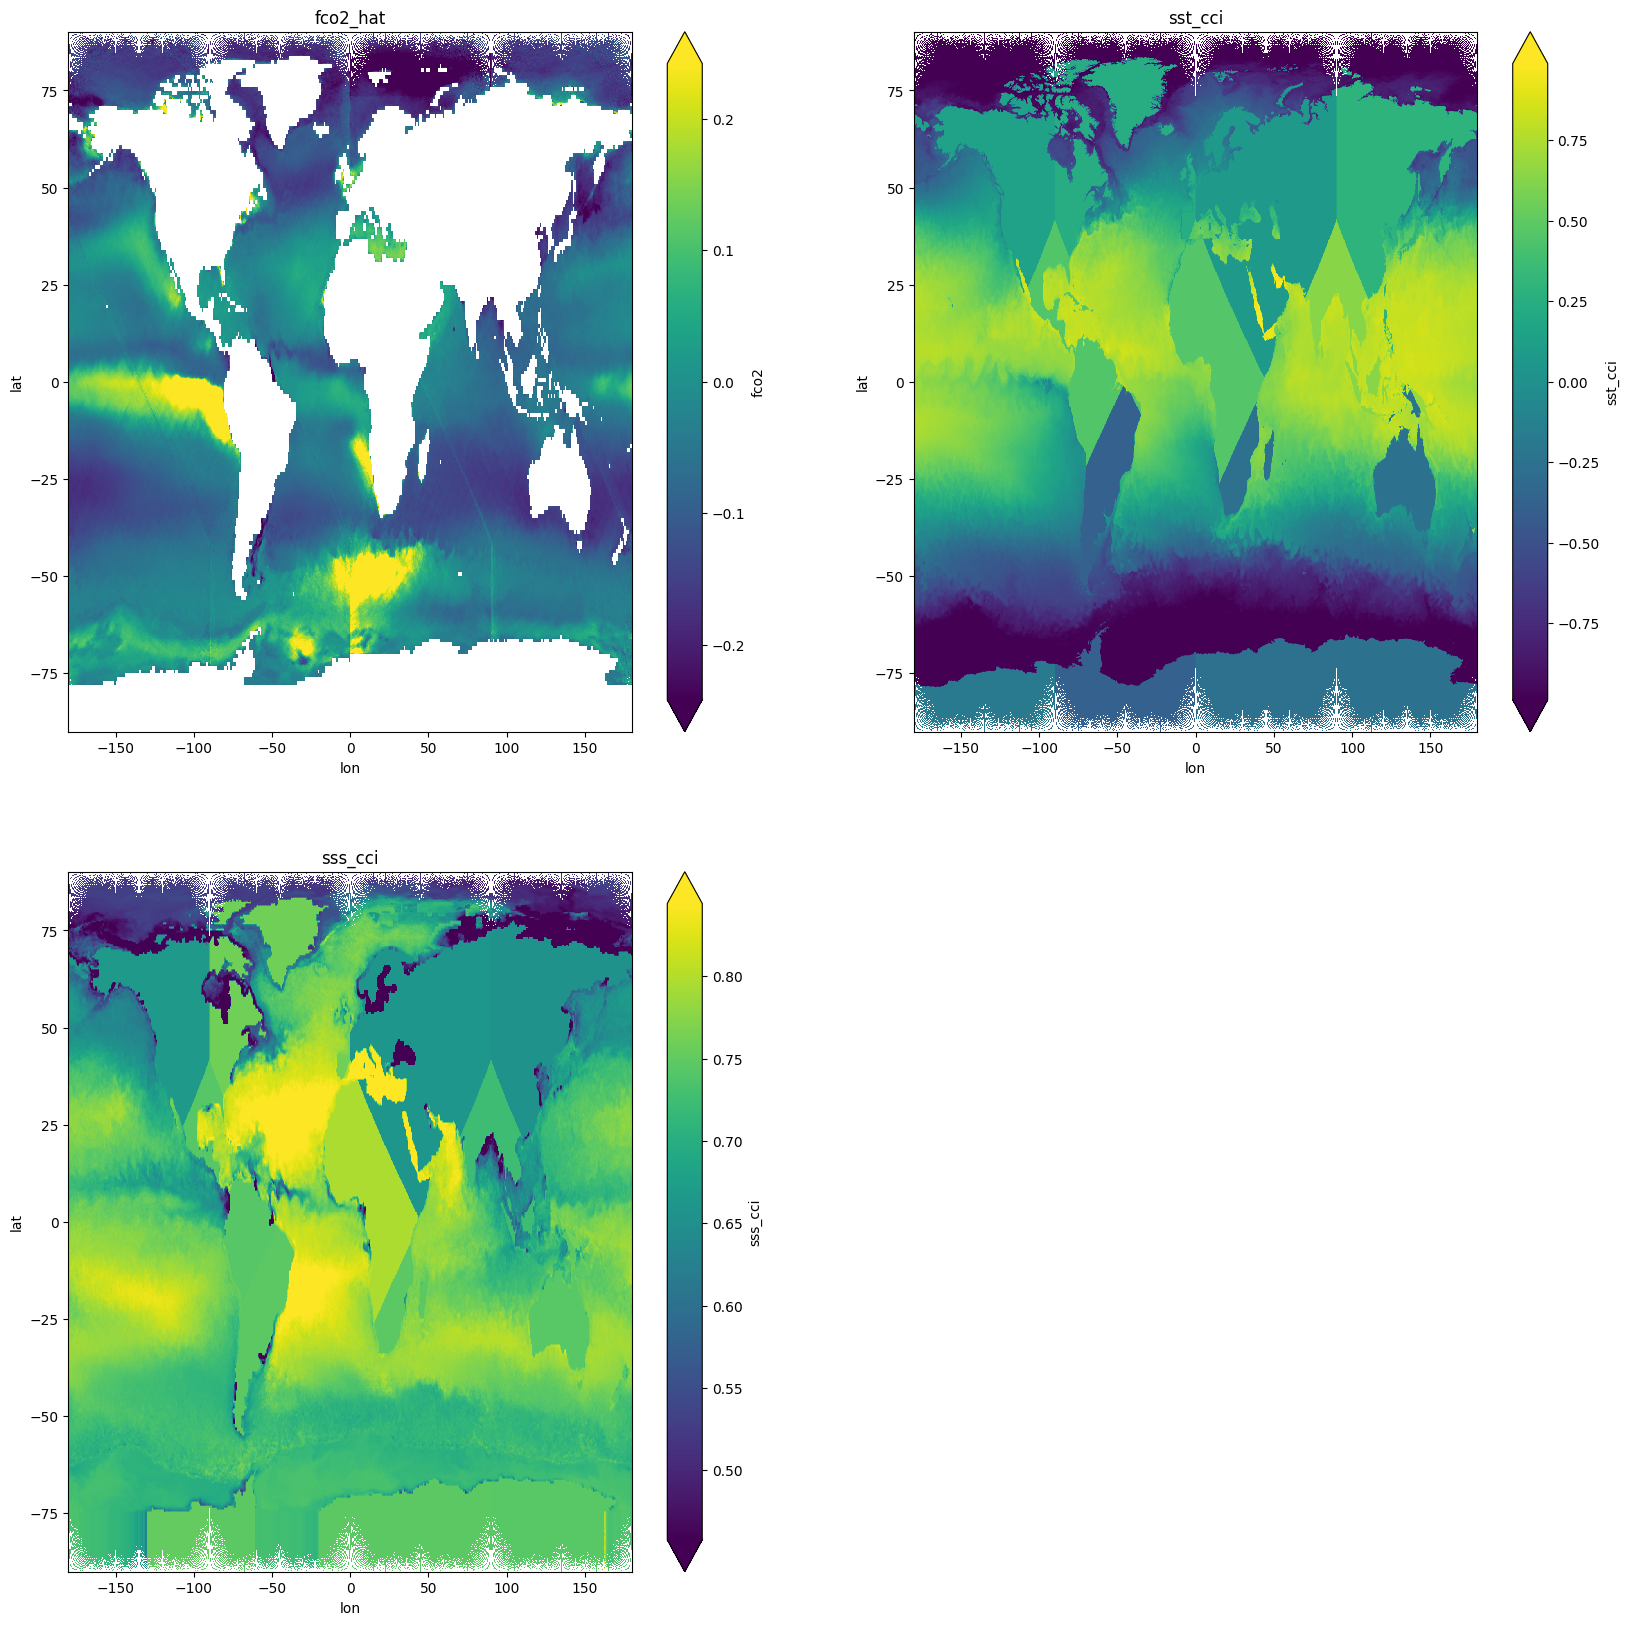

In [33]:
fig, axs = plt.subplots(2,2, figsize=(20, 20))
plot_ds = sample_ds#.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
plot_ds.fco2.plot(ax=axs[0, 0], robust=True,cmap="viridis")
axs[0, 0].set_title("fco2_hat")
plot_ds.sst_cci.plot(ax=axs[0, 1], robust=True, cmap="viridis")
axs[0, 1].set_title("sst_cci")
plot_ds.sss_cci.plot(ax=axs[1, 0], robust=True, cmap="viridis")
axs[1, 0].set_title("sss_cci")
axs[1,1].set_visible(False)
plt.show()

In [ ]:
fig.savefig("healpix_shifts2.png", bbox_inches="tight")

In [8]:
import torch
from tqdm import tqdm
import healpy as hp
import numpy as np
from fco2models.utraining import prep_df
import time


def segment_ds(data, orientation, segment_len=64):
    side, _, num_cols = data.shape

    if orientation == 'vertical':
        data = np.transpose(data, (1, 0, 2))
    elif not (orientation == 'horizontal'):
        raise ValueError(f"Unknown orientation {orientation}")
    segments = np.zeros(( (side**2) // segment_len, num_cols, segment_len), dtype=np.float32)
    for i in range(num_cols):
        segments[:, i, :] = data[:, :, i].reshape((side ** 2) // segment_len, segment_len)
    return segments


def fdf_to_numpy(df, cols, nside):
    fnpix = df.shape[0]
    fpix = np.arange(fnpix)
    xyf = hp.pix2xyf(nside, fpix, nest=True)
    x,y = xyf[0], xyf[1]
    fds = np.full((nside, nside, len(cols)), np.nan, dtype=np.float32)
    fds[x, y, :] = df.values
    assert np.isnan(df.values[:, 0]).sum() == 0, "NaN values found in dataframe" # there should be no NaN values in the sample column (every coordinate should have a sample)
    assert np.isnan(fds[:, :, 0]).sum() == 0, "NaN values found in fds" # there should be no NaN values in the sample column (every coordinate should have a sample)
    return fds, x, y

def do_step_loader(model, noise_scheduler, dataloader, t, device, jump):
    samples = []
    for (ix, batch) in enumerate(dataloader):
        with torch.no_grad():
            batch = batch.to(device)
            sample_prev = batch[:, 0:1, :].to(device)
            #sample_prev = noise_scheduler.add_noise(sample_prev, torch.randn_like(sample_prev), t)
            noise_pred = model(batch, t, return_dict=False)[0]
            x_0 = noise_scheduler.step(noise_pred, t, sample_prev).pred_original_sample
            if jump is None:
                sample = noise_scheduler.step(noise_pred, t, sample_prev).prev_sample
            elif t - jump > 0:
                #sample = x_0 
                sample = noise_scheduler.add_noise(x_0, torch.randn_like(sample_prev), t - jump)
            else:
                sample = x_0
                #sample = noise_scheduler.step(noise_pred, t, sample_prev).prev_sample
            sample[torch.isnan(sample)] = sample_prev[torch.isnan(sample)]
            samples.append(sample.cpu().numpy())
    return np.concatenate(samples, axis=0)

def do_random_rot(lon, lat):
        random_zrotation = np.random.random() * 360
        rot = hp.Rotator(rot=(random_zrotation, 0, 0), eulertype="ZYX") # rotate only around the z-axis, so we do not mix equatirial and polar coordinates
        lon_rot, lat_rot = rot(lon, lat, lonlat=True)
        m_rot = hp.ang2pix(nside, lon_rot, lat_rot, nest=True, lonlat=True)
        return m_rot


def infer_patch_with_rotations(model, noise_scheduler, params, date, nside=1024, jump=None, n_samples=1):

    npix = hp.nside2npix(nside)
    print(f"Number of pixels: {npix}")
    m = np.arange(npix)
    lon, lat = hp.pix2ang(nside, m, nest=True, lonlat=True)
    sample = np.random.randn(npix, 1).astype(np.float32)
    dss = get_day_dataset(date)
    context_df = collocate_coords(pd.DataFrame({
        'lon': lon.flatten(),
        'lat': lat.flatten(),
        'time_1d': date,
        }), dss, date)
    print(f"Collocated data shape: {context_df.shape}")
    
    context_df['lon'] = (context_df['lon'] + 180) % 360 - 180
    df = prep_df(context_df, with_target=False, with_log=True)[0]
    df['sst_clim'] += 273.15
    df['sst_anom'] = df['sst_cci'] - df['sst_clim']
    df['sss_anom'] = df['sss_cci'] - df['sss_clim']
    df['chl_anom'] = df['chl_globcolour'] - df['chl_clim']
    df['ssh_anom'] = df['ssh_sla'] - df['ssh_clim']
    df['mld_anom'] = df['mld_dens_soda'] - df['mld_clim']
    context_df = df.loc[:, params['predictors']]
    stats = {
        'means': params['train_means'],
        'stds': params['train_stds'],
        'mins': params['train_mins'],
        'maxs': params['train_maxs']
    }
    context_df = normalize(context_df,stats, params['mode'])
    #context_df = context_df.fillna(context_df.mean())
    print(f"Preprocessed data shape: {context_df.shape}")
    
    # add sample and metadata
    context_df['healpix_id'] = m
    context_df['m_rotated'] = m  # placeholder for rotated healpix id
    context_df.set_index('healpix_id', inplace=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    #t_loop_jump = noise_scheduler.timesteps[::jump][:-1]
    #t_loop_full = torch.arange(jump-1, 0, -1)
    #print(f"t_loop_jump: {t_loop_jump}, t_loop_full: {t_loop_full}")
    #t_loop = tqdm(torch.cat((t_loop_jump, t_loop_full)), desc="Denoising steps")
    for i in range(n_samples):
        #cols = [f'sample_{i}'] + params['predictors']
        context_df[f'sample_{i}'] = np.random.randn(npix).astype(np.float32)
    
    t_loop = tqdm(noise_scheduler.timesteps[::jump], desc="Denoising steps")
    step = 0
    for t in []:#t_loop:
        context_df['m_rotated'] = do_random_rot(lon, lat)
        for i in range(n_samples):
            cols = [f'sample_{i}'] + params['predictors']
            #context_df[f'sample_{i}'] = np.random.randn(npix).astype(np.float32)
            
            for face in range(12):
                fnpix = npix // 12 
                fpixs = np.arange(face * fnpix, (face + 1) * fnpix)
                fpixs_rotated = context_df.loc[fpixs, 'm_rotated']
                
                df = context_df.loc[fpixs_rotated, cols]
                fds, x, y = fdf_to_numpy(df, cols, nside)

                if step % 2 == 0:
                    segments = segment_ds(fds, 'horizontal', segment_len=64)
                else:
                    segments = segment_ds(fds, 'vertical', segment_len=64)

                ds = torch.from_numpy(segments).to(device).float()
                ds = torch.cat((ds, torch.ones_like(ds[:, 0:1, :])), axis=1)
                dataloader = torch.utils.data.DataLoader(ds, batch_size=500, shuffle=False)

                samples = do_step_loader(model, noise_scheduler, dataloader, t, device, jump)
                
                samples = samples.reshape(nside, nside)
                context_df.loc[fpixs_rotated, f'sample_{i}'] = samples[x, y] if step % 2 == 0 else samples[y, x]
                t_loop.set_postfix({"face": {face}, "sample": {i}})

        step += 1
    return context_df


There was a problem when trying to write in your cache folder (/home/jovyan/.cache/huggingface/hub). Please, ensure the directory exists and can be written to.
/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  "to undesirable behaviors or errors. To avoid these issues, avoid "
/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  "this condition will fail. "


In [9]:
import pandas as pd
from fco2models.models import UNet2DModelWrapper, Unet2DClassifierFreeModel
from fco2models.ueval import load_model
# load baseline model
save_path = '../models/meanstd_mini/'
model_path = 'e_300.pt'
model_class = UNet2DModelWrapper
model, noise_scheduler, params, losses = load_model(save_path, model_path, model_class,training_complete=True)
print("model loaded")
print("predictors:", params['predictors'])
date = pd.Timestamp('2022-10-04')
nside = 1024

model loaded
predictors: ['sst_anom', 'sss_anom', 'chl_anom', 'ssh_anom', 'mld_anom', 'sst_clim', 'sss_clim', 'chl_clim', 'ssh_clim', 'mld_clim', 'xco2', 'co2_clim8d']


In [116]:
from diffusers import DDIMScheduler
#model.set_w(0)
ddim_scheduler = DDIMScheduler(
    num_train_timesteps=noise_scheduler.config.num_train_timesteps,
    beta_schedule=noise_scheduler.config.beta_schedule,
    clip_sample_range=noise_scheduler.config.clip_sample_range
    )
ddim_scheduler.set_timesteps(50)
df = infer_patch_with_rotations(model, ddim_scheduler, params, date, nside=nside, jump=None, n_samples=1)
#df.to_parquet('healpix_cfree_one.pq')

Number of pixels: 12582912
All files reachable for date 2022-10-04 00:00:00
globcolour data already exists at ../data/inference/gridded_2022-10-04/globcolour.nc
soda data already exists at ../data/inference/gridded_2022-10-04/soda.nc
cmems data already exists at ../data/inference/gridded_2022-10-04/cmems.nc
sss_cci data already exists at ../data/inference/gridded_2022-10-04/sss_cci.nc
sss_multiobs data already exists at ../data/inference/gridded_2022-10-04/sss_multiobs.nc
sst_cci data already exists at ../data/inference/gridded_2022-10-04/sst_cci.nc
Reading globcolour data from ../data/inference/gridded_2022-10-04/globcolour.nc
Reading soda data from ../data/inference/gridded_2022-10-04/soda.nc
Reading cmems data from ../data/inference/gridded_2022-10-04/cmems.nc
Reading sss_cci data from ../data/inference/gridded_2022-10-04/sss_cci.nc
Reading sss_multiobs data from ../data/inference/gridded_2022-10-04/sss_multiobs.nc
Reading sst_cci data from ../data/inference/gridded_2022-10-04/sst_c

2025-06-24 13:12:47,460 - INFO - salinity stacking
2025-06-24 13:12:47,549 - INFO - adding positional and temporal encodings
2025-06-24 13:12:50,743 - INFO - add climatology data
2025-06-24 13:13:08,114 - INFO - adding xco2 data
2025-06-24 13:13:15,284 - INFO - adding seamask data
2025-06-24 13:13:22,364 - INFO - adding climatology data
2025-06-24 13:13:54,895 - INFO - adding climatology data


Preprocessed data shape: (12582912, 12)


Denoising steps:   0%|          | 0/50 [00:00<?, ?it/s]


In [10]:
import pandas as pd
df = pd.read_parquet("./healpix_meanstd_fco2hat.pq")

In [11]:
df.columns

Index(['sst_cci', 'sss_cci', 'chl_globcolour', 'ssh_sla', 'mld_dens_soda',
       'xco2', 'co2_clim8d', 'sin_day_of_year', 'cos_day_of_year', 'sin_lat',
       'sin_lon_cos_lat', 'cos_lon_cos_lat', 'm_rotated', 'sample_0',
       'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5', 'sample_6',
       'sample_7', 'sample_8', 'sample_9', 'sample_10', 'sample_11',
       'sample_12', 'sample_13', 'sample_14', 'sample_15', 'sample_16',
       'sample_17', 'sample_18', 'sample_19'],
      dtype='object')

In [12]:
params['train_mins']

[-390.85729311489627,
 -14.535430908203125,
 -38.41282653808594,
 -1.7192974090576172,
 -2.9997119903564453,
 -2.9107136726379395,
 271.3144836425781,
 5.5685930252075195,
 -2.636031150817871,
 -1.505947232246399,
 0.0,
 334.0219236315376,
 -222.32705688476562]

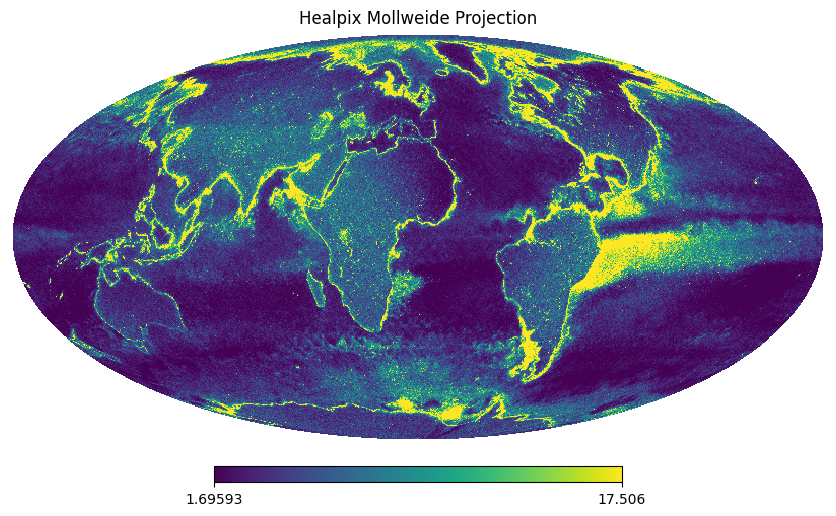

In [23]:
nside = 1024
sample_cols = [f"sample_{i}" for i in range(20)]
#df[sample_cols] =df[sample_cols] * params['train_stds'][0] + params['train_means'][0]
#df[sample_cols] =(df[sample_cols] + 1) * (params['train_maxs'][0] - params['train_mins'][0]) / 2 + params['train_mins'][0]
df['sample_mean'] = df[sample_cols].mean(axis=1)
df['sample_std'] = df[sample_cols].std(axis=1)
sample_col = "sample_std"
data = np.full((hp.nside2npix(nside), ), np.nan, dtype=np.float32)
data[df.index] = df[sample_col].values
data = np.clip(data, np.nanpercentile(data, 5), np.nanpercentile(data, 95))
hp.mollview(data, title="Healpix Mollweide Projection", nest=True, cmap='viridis')

In [24]:
params['mode']

'mean_std'

In [25]:
import xarray as xr
lon, lat = hp.pix2ang(nside, df.index.values, nest=True, lonlat=True)
#df['lon'] = (lon + 180) % 360 - 180
#df['lat'] = lat
#df.set_index(['lon', 'lat'], inplace=True)
#sample_ds = xr.Dataset.from_dataframe(df[['sample_col'] + predictors])
sample_ds = pd.DataFrame({
    'lon': (lon + 180) % 360 - 180,
    'lat': lat,
    'fco2_hat': df[sample_col].values,
    'sst_cci': df['sst_cci'].values,
    'sss_cci': df['sss_cci'].values,
    #'sst_clim': df['sst_clim'].values,
    #'sss_clim': df['sss_clim'].values,
    #'seamask': df['seamask'].values
})
print(sample_ds.lon.min(), sample_ds.lon.max(), sample_ds.lat.min(), sample_ds.lat.max())
sample_ds['lon'] = np.round(sample_ds['lon']*4, 0) / 4
sample_ds['lat'] = np.round(sample_ds['lat']*4, 0) / 4
sample_ds.set_index(['lon', 'lat'], inplace=True)
sample_ds = sample_ds.groupby(['lat', 'lon']).mean().to_xarray()

-180.0 179.9560546875 -89.95431463934247 89.95431463934247


In [26]:
import xarray as xr
#df = df.reset_index()
masks = xr.open_dataset(DATA_PATH+"masks/RECCAP2_masks.nc")
masks2 = masks.reindex_like(sample_ds, method='nearest')
sample_ds = xr.merge([sample_ds, masks2])
#sample_ds["seamask"] = masks.seamask.sel(sample_ds[['lat', 'lon']], method="nearest")
#sample_ds.set_index(['lon', 'lat'], inplace=True)
#sample_ds.sample[~(sample_ds.seamask.astype(bool))] = np.nan

In [27]:
malvinas = (-71, -56, -35, -11)  # (lon_min, lat_min, lon_max, lat_max)
eq_pacific = (-144, -18, -63, 18) 
cali = (-149, 22, -107, 48)
papayo = (-108.281250,0.439449,-66.708984,23.079732)
nw_africa = (-41.748047,3.776559,-9.404297,27.800210)
box = (-180, 0, 0, 75)
lon_min, lat_min, lon_max, lat_max = malvinas

In [28]:
sample_ds.fco2_hat.where(sample_ds.seamask==1).mean()

<xarray.DataArray 'fco2_hat' ()> Size: 8B
array(6.17836761)

8.13354206085205
7.6979241371154785


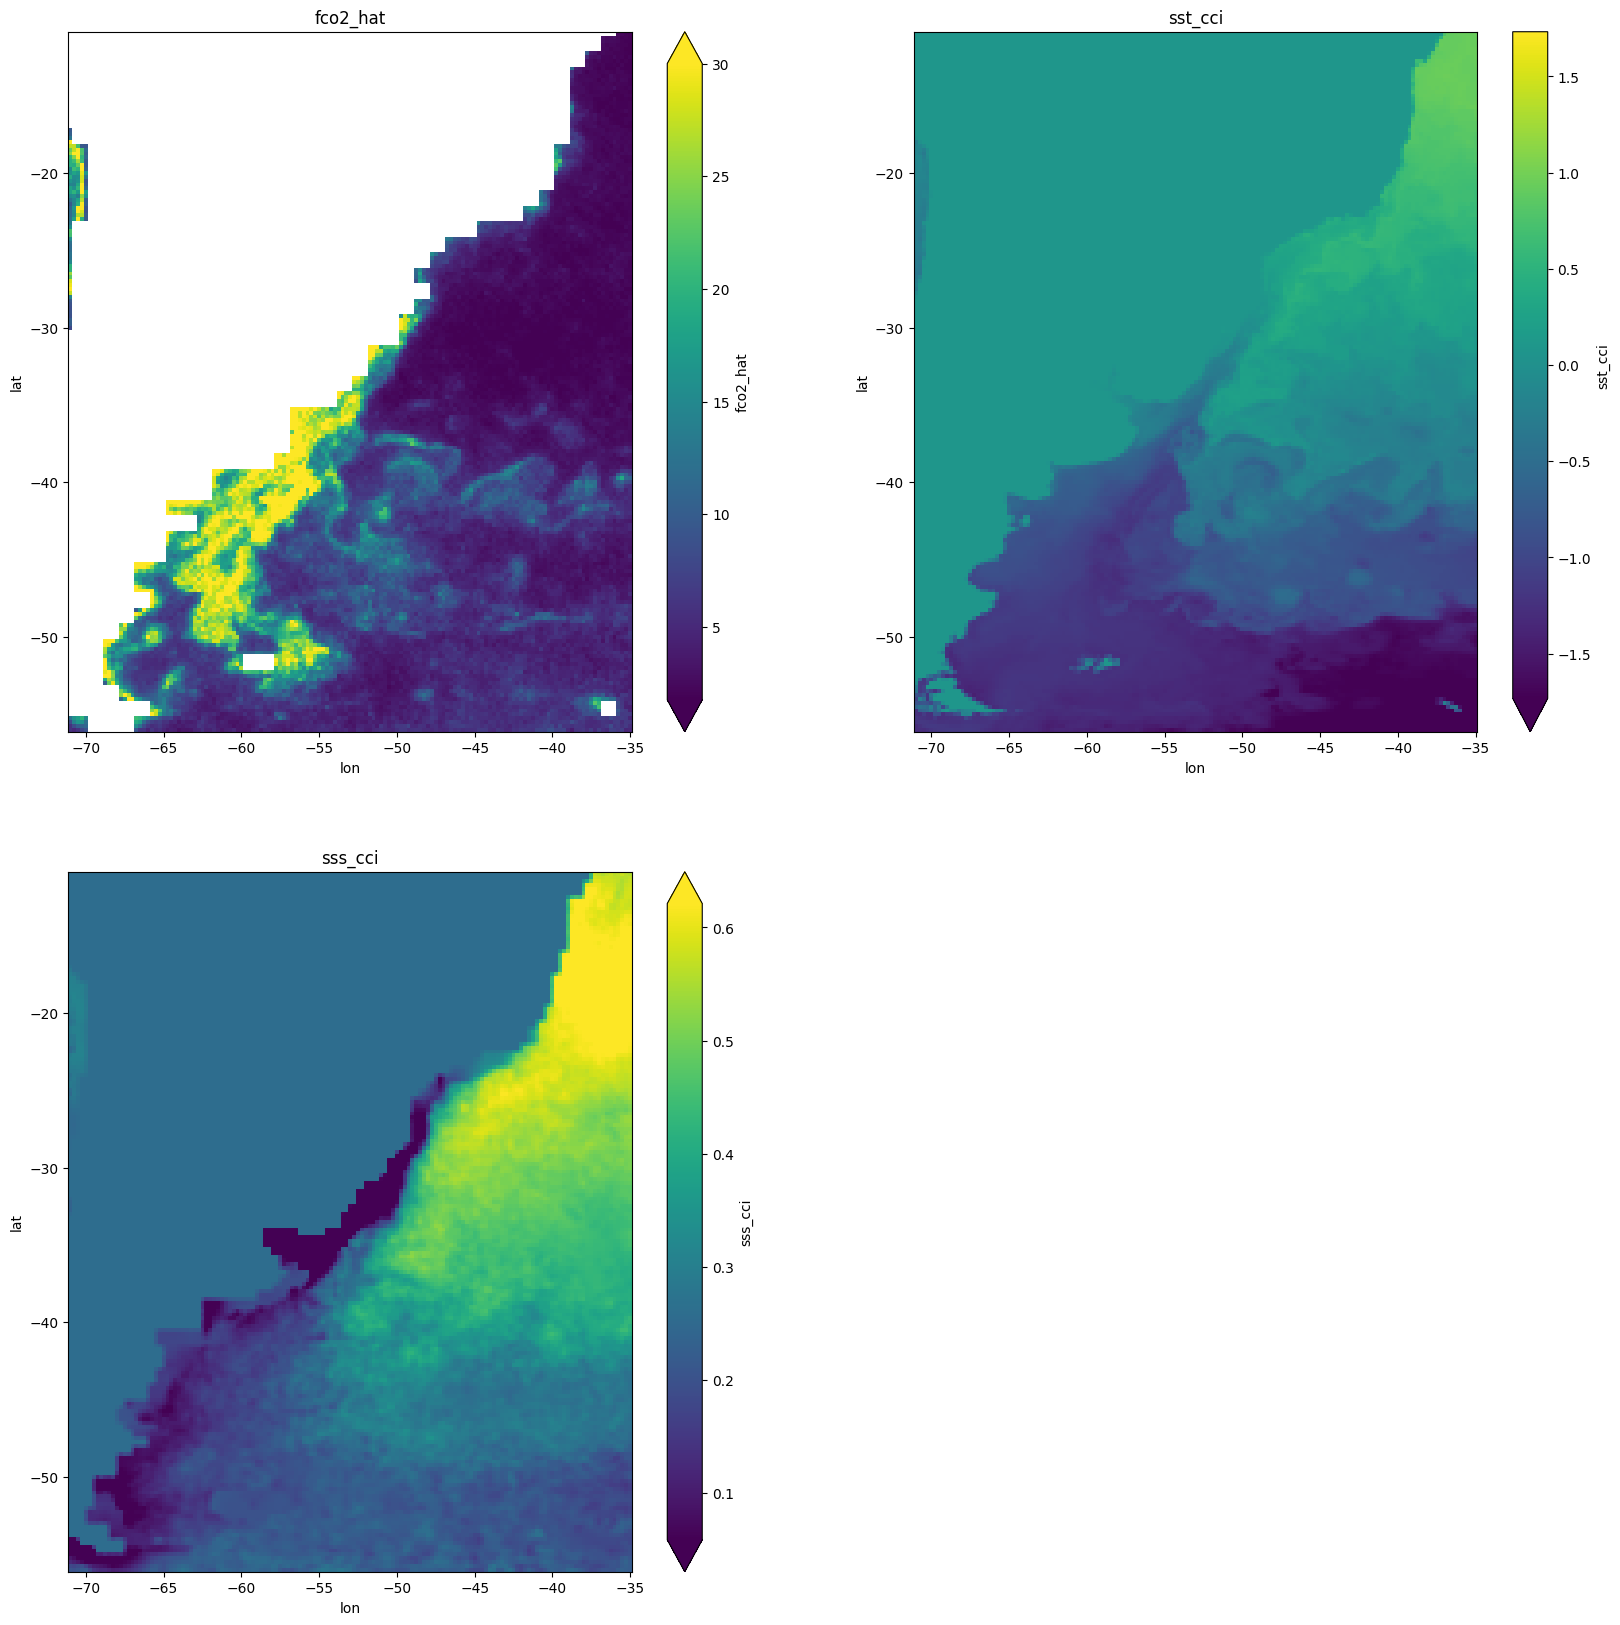

In [31]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2, figsize=(20, 20))
plot_ds = sample_ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
print(plot_ds.fco2_hat.where(plot_ds.seamask==1).mean().item())
print(plot_ds.fco2_hat.where(plot_ds.seamask==1).std().item())
plot_ds.fco2_hat.where(plot_ds.seamask==1).plot(ax=axs[0, 0], robust=True, cmap="viridis", vmax=30)
axs[0, 0].set_title("fco2_hat")
plot_ds.sst_cci.plot(ax=axs[0, 1], robust=True, cmap="viridis")
axs[0, 1].set_title("sst_cci")
plot_ds.sss_cci.plot(ax=axs[1, 0], robust=True, cmap="viridis")
axs[1, 0].set_title("sss_cci")
axs[1,1].set_visible(False)
plt.show()

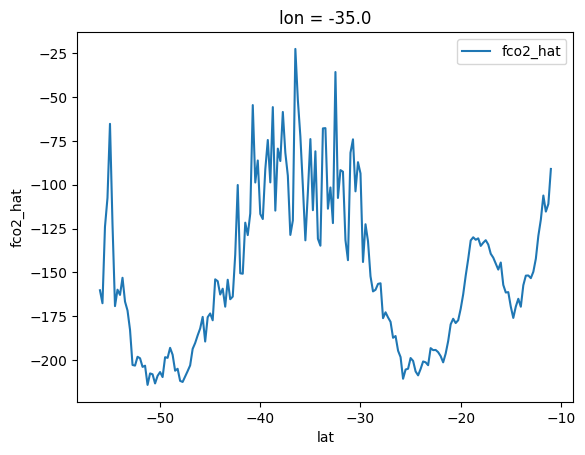

In [156]:
fig, ax = plt.subplots()
lat_plot = slice(lat_min, lat_max)
lon_plot = lon_max
sample_ds.fco2_hat.sel(lat=lat_plot, lon=lon_plot).plot(ax=ax, label='fco2_hat')
#sample_ds.sst_cci.sel(lat=lat_plot, lon=lon_plot).plot(ax=ax, label='sst_cci')
#sample_ds.sss_cci.sel(lat=lat_plot, lon=lon_plot).plot(ax=ax, label='sss_cci')
fig.show()
ax.legend()

In [19]:
fig.savefig("healpix_rotations_20.png", bbox_inches="tight")